In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import pickle
import nltk
import seaborn as sns
import os
import re 
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance
from gensim.models import Word2Vec

In [5]:
from clustering.embedding import WordEmbedding

In [6]:
#!python -m spacy download es_core_news_sm
#!python -m spacy download es_core_news_md
#nltk.download('punkt')
#nltk.download('wordnet')

In [7]:
df = pd.read_csv('data/datos_estructurados_malba')

<AxesSubplot:xlabel='Año', ylabel='Count'>

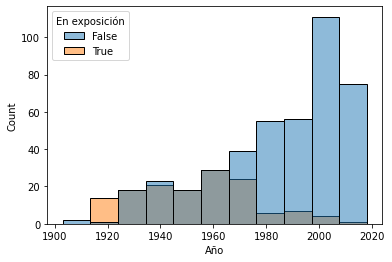

In [8]:
sns.histplot(data=df,x='Año',hue='En exposición',)

In [9]:
df.columns

Index(['URL_obra', 'Texto', 'URL_autor', 'Titulo', 'Año', 'Técnica', 'Medidas',
       'Nro. de inventario', 'Donación', 'En exposición', 'Duración'],
      dtype='object')

In [10]:
len(df['Técnica'].unique())

351

In [11]:
df['Técnica'].value_counts()

Óleo sobre tela                        43
Copia heliográfica sobre papel. x/∞    25
Tinta sobre papel                      15
Lápiz sobre papel                      14
Cartón y papel pintado                 12
                                       ..
Bronce y madera pintada                 1
Carbonilla y tinta sobre papel          1
Video HD 16:9                           1
Esmalte sobre madera                    1
Mixta. Serigrafía y tubo de cartón      1
Name: Técnica, Length: 350, dtype: int64

In [12]:
textos = (df.dropna(subset=['Texto']).Texto.values)

In [13]:
len(textos)

277

In [14]:
texto = "".join(textos).strip()

In [15]:
len(texto)

1542053

# Preprocesamos

Vamos a preprocesar:
- Eliminamos los números de las notas al pie, que son los números precedidos por puntos (.2 Blahblah)
- Reemplazamos \n3, \n, s\p por espacios
- Separamos en oraciones
- Lowercase todo
- Nos deshacemos de caracteres especiales
- Nos deshacemos de oraciones muy cortas

In [16]:
#texto = "Texto de Agustin Díez Fischer\n\xa0\nNotas\n1."

In [17]:
texto_limpio = re.sub("\d?\\n\d?\.?", "", texto)
texto_limpio = re.sub("\.\d", ". ", texto_limpio)
texto_limpio = re.sub("s\/p\.", ". ", texto_limpio)
puntos_mal = re.findall(".?\.[A-Z]",texto_limpio)

In [18]:
for elem in puntos_mal:
    if len(elem) == 2:
        repl = (elem[0] + ' ' + elem[1])
    elif len(elem) == 3:
        repl = (elem[0] + elem[1] + ' ' + elem[2])
    texto_limpio = texto_limpio.replace(elem, repl)

# Utilizamos contexto de oraciones 

In [19]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize.punkt import PunktTrainer, PunktSentenceTokenizer

In [20]:
pt = PunktSentenceTokenizer(texto,verbose=True)

In [21]:
sentences = pt.tokenize(texto)

In [22]:
len(sentences)

7048

In [23]:
sentences_len = [len(s) for s in sentences]

<AxesSubplot:ylabel='Count'>

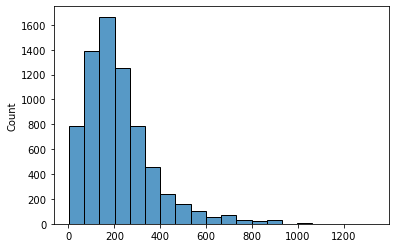

In [24]:
sns.histplot(x=sentences_len,bins=20)

In [25]:
sent_df = pd.DataFrame({'sent':sentences,'leng':sentences_len})

In [26]:
sent_df.sample(n=10)

,sent,leng
246,"Gradowczyk, Mario y Perazzo, Nelly (curs.",41
3635,Como señaló Fabián Lebenglik: “En conjunto con...,396
1148,"O sea que no hay presente, pasado y futuro.4\n...",251
6959,Esa referencia a la tradición judeocristiana s...,637
3249,"En esta ávida búsqueda de crear cosas nuevas, ...",291
919,"Así, junto a la muda presencia de esta escenog...",470
4175,Guttero forma parte de ese grupo de artistas q...,478
3145,Retrospectiva.,14
5430,El formato tradicional del bastidor es alterad...,399
5278,El modelo I remitía directamente a la conocida...,444


In [27]:
len_threshold = 30
mask = sent_df['leng'] < len_threshold

In [28]:
sent_df[mask].count()

sent    253
leng    253
dtype: int64

In [29]:
sent_df[mask].sample(n=30)

,sent,leng
5623,2.,2
406,Retrato publicado en Áurea.,27
2954,Retrospectiva.,14
57,Claudia Andujar.,16
2157,No de forma consciente.,23
347,Teoría y táctica.,17
4041,Una retrospectiva.,18
1768,Buenos Aires 1936.,18
5959,8.,2
372,Teoría y táctica.,17


In [30]:
sent_df_long = sent_df[~mask]

In [31]:
sentences = sent_df_long.sent.values

In [32]:
np.random.choice(sentences,size=20)

array(['Como en las xerografías –fotocopias realizadas con máquinas Xerox, que fueron utilizadas experimentalmente por varios artistas paulistas–, estos usos creativos de la máquina marcaron el interés de Ferrari por la obra accesible, intercambiable, con un soporte no valorizado y con una acción artística que, ante todo, introdujo un modo de circulación alternativa y marginal en relación con la que prevalece en el campo de las artes visuales.',
       'Así, en los años de expansión del VIH-sida y en un contexto próximo a la conmemoración de los cinco siglos de la “conquista” de América, cuando se reactivan los debates sobre la colonialidad, Casas y Lemebel travisten a Frida para disputar los usos exotizantes de su figura.',
       'Godofredo Iommi recuerda que su cuñado Santiago Girola, padre de Enio, al ver un dibujo realizado por el entonces joven hijo, comentó: “Este chico tiene las proporciones innatas”.',
       'Desde principios de los años 60 hasta la actualidad, Noé ha desarro

# Tokenizamos y limpiamos un poco más

In [33]:
nlp = spacy.load("es_core_news_sm")

In [34]:
def normalize(text):
    text = text.lower()
    # Quitamos los guiones y los reemplazamos por espacios
    text = re.sub('-', ' ', text)
    # Quitamos caracteres espaeciales excepto acentos y dieresis
    text = re.sub('[^A-Za-z0-9  áéíóúÁÉÍÓÚüÜïÏÿñ]+', '', text)
    return text

def keep_token(token):
    return t.isalpha()

def tokenize(text):
    tokens = text.split(' ')
    return [t for t in tokens if t.isalpha()]

In [35]:
sents_tokens = [tokenize(normalize(sent)) for sent in sentences]

In [36]:
sentences[2]

'Ejemplo paradigmático del artista global, ha observado y pensado las realidades metropolitanas de todo el mundo, ha hecho obras sobre fronteras y guerras, y también se ha fascinado con las formas y metáforas de ciertos fenómenos climáticos.'

In [37]:
sents_tokens[2]

['ejemplo',
 'paradigmático',
 'del',
 'artista',
 'global',
 'ha',
 'observado',
 'y',
 'pensado',
 'las',
 'realidades',
 'metropolitanas',
 'de',
 'todo',
 'el',
 'mundo',
 'ha',
 'hecho',
 'obras',
 'sobre',
 'fronteras',
 'y',
 'guerras',
 'y',
 'también',
 'se',
 'ha',
 'fascinado',
 'con',
 'las',
 'formas',
 'y',
 'metáforas',
 'de',
 'ciertos',
 'fenómenos',
 'climáticos']

In [38]:
sents_joined_tokens = [" ".join(s) for s in sents_tokens]

# Triplas de dependencia

In [37]:
nlp = spacy.load("es_core_news_sm")
nlp.max_length = 2000000

In [38]:
doc = nlp(texto_limpio)

In [39]:
sent_threshold = 30

In [40]:
sents = [sent for sent in doc.sents if len(sent) > sent_threshold]

words = []
words_lemma = []
for sent in sents:
    for word in sent:
        if word.is_alpha:
            words.append(word)
            words_lemma.append(word.lemma_)
            
counts = Counter(words_lemma)

In [41]:
len(counts)

13119

In [42]:
def parse_tags(word):
    tags = word.tag_[len(word.pos_) + 2:]
    tags = tags.split("|")
    return tags

lemma_file = open("clustering/lemmatization-es.txt", "r")
lemma_raw = lemma_file.read()
lemma = lemma_raw.split("\n")

In [43]:
lemma

['1\tprimer',
 '1\tprimera',
 '1\tprimeras',
 '1\tprimero',
 '1\tprimeros',
 '10\tdécima',
 '10\tdécimas',
 '10\tdécimo',
 '10\tdécimos',
 '100\tcentésima',
 '100\tcentésimas',
 '100\tcentésimo',
 '100\tcentésimos',
 '1000\tmilésima',
 '1000\tmilésimas',
 '1000\tmilésimo',
 '1000\tmilésimos',
 '10000\tdiezmilésima',
 '10000\tdiezmilésimas',
 '10000\tdiezmilésimo',
 '10000\tdiezmilésimos',
 '100000\tcienmilésima',
 '100000\tcienmilésimas',
 '100000\tcienmilésimo',
 '100000\tcienmilésimos',
 '1000000\tmillonésima',
 '1000000\tmillonésimas',
 '1000000\tmillonésimo',
 '1000000\tmillonésimos',
 '10000000\tdiezmillonésima',
 '10000000\tdiezmillonésimas',
 '10000000\tdiezmillonésimo',
 '10000000\tdiezmillonésimos',
 '100000000\tcienmillonésima',
 '100000000\tcienmillonésimas',
 '100000000\tcienmillonésimo',
 '100000000\tcienmillonésimos',
 '1000000000\tmilmillonésima',
 '1000000000\tmilmillonésimas',
 '1000000000\tmilmillonésimo',
 '1000000000\tmilmillonésimos',
 '10000000000\tdiezmilmillonés

In [44]:
lemma_dict = {}
for pair in lemma:
    w = pair.split("\t")
    if len(w) == 2:
        lemma_dict[w[1]] = w[0]

In [45]:
def lemmatize(word):
    if word in lemma_dict:
        word = lemma_dict[word]
    return word

In [46]:
len(words)

184933

In [47]:
# Crear diccionario
dicc = {}
list_dicc = {}
word_id = 0
threshold_w = 3
threshold_c = 1

for word in words:
    w = lemmatize(word.lemma_)
    if not word.is_alpha or str.isdigit(w) or counts[w] < threshold_w:
        continue
    if not w in dicc:
        features = {}
    else:
        features = dicc[w]

    pos = "POS__" + word.pos_
    if not pos in features:
        features[pos] = 0
    features[pos] += 1

    dep = "DEP__" + word.dep_
    if not dep in features:
        features[dep] = 0
    features[dep] += 1

    tags = parse_tags(word)
    for tag in tags:
        if not tag in features:
            features[tag] = 0
        features[tag] += 1

    if not word.i == 0:
        context_izq = doc[word.i - 1]
        c_izq = lemmatize(context_izq.lemma_)
        if context_izq.is_alpha and counts[c_izq] > threshold_c:
            if str.isdigit(c_izq):
                c_izq = "NUM__"
            if not c_izq in features:
                features[c_izq] = 0
            features[c_izq] += 1

    if not word.i < len(doc):
        context_der = doc[word.i + 1]
        c_der = lemmatize(context_der.lemma_)
        if context_der.is_alpha and counts[c_der] > threshold_c:
            if str.isdigit(c_der):
                c_der = "NUM__"
            if not c_der in features:
                features[c_der] = 0
            features[c_der] += 1

    tripla = "TRIPLA__" + w + "__" + word.lemma_ + "__" + word.dep_ + "__" + lemmatize(word.head.lemma_)
    if not tripla in features:
        features[tripla] = 0
    features[tripla] += 1

    word_id += 1

    dicc[w] = features

In [48]:
len(dicc)

4923

In [49]:
features = []
key_words = {}
wid = 0
for d in dicc:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features.append(dicc[d])

In [50]:
len(features)

4923

In [51]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features)

In [52]:
matrix.shape

(4923, 81066)

In [53]:
matrix_normed = matrix / matrix.max(axis=0)

In [54]:
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))

In [55]:
threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

In [56]:
red_matrix.shape

(4923, 154)

In [57]:
matrix_normed.shape

(4923, 81066)

In [58]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

In [59]:

pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

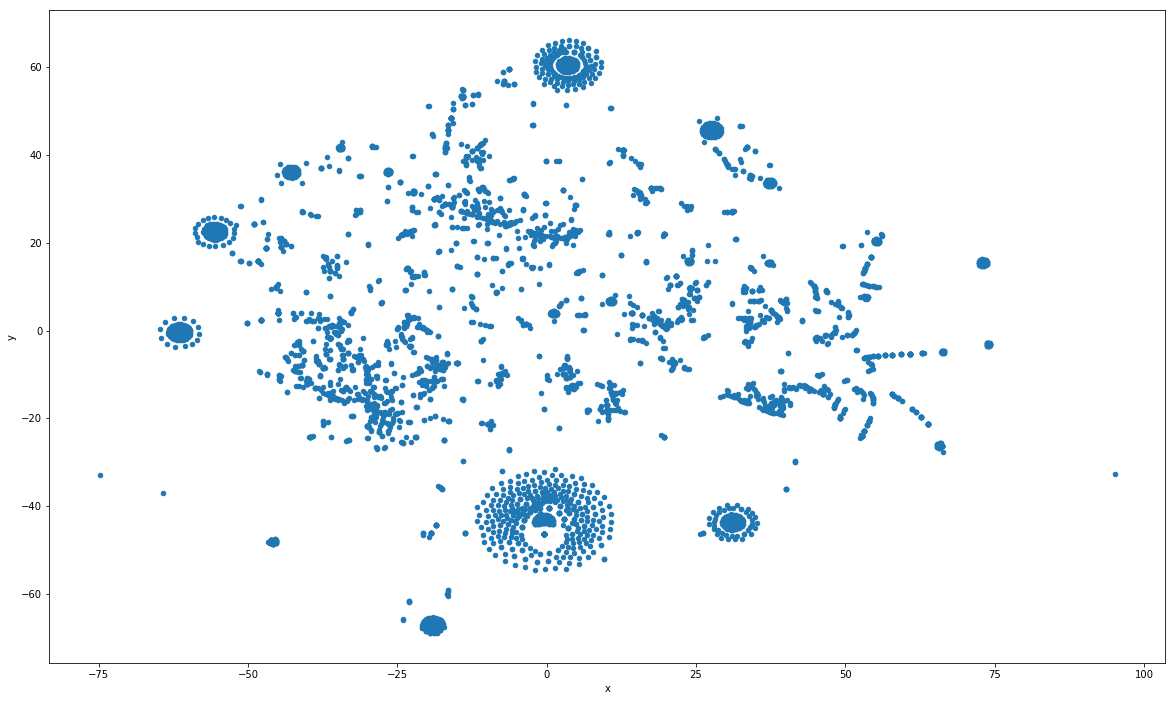

In [60]:

pointsspacy.plot.scatter("x", "y", s=20, figsize=(20, 12))

In [61]:
def plot_region(x_bounds, y_bounds):
    slice = pointsspacy[
        (x_bounds[0] <= pointsspacy.x) &
        (pointsspacy.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointsspacy.y) &
        (pointsspacy.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(20, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

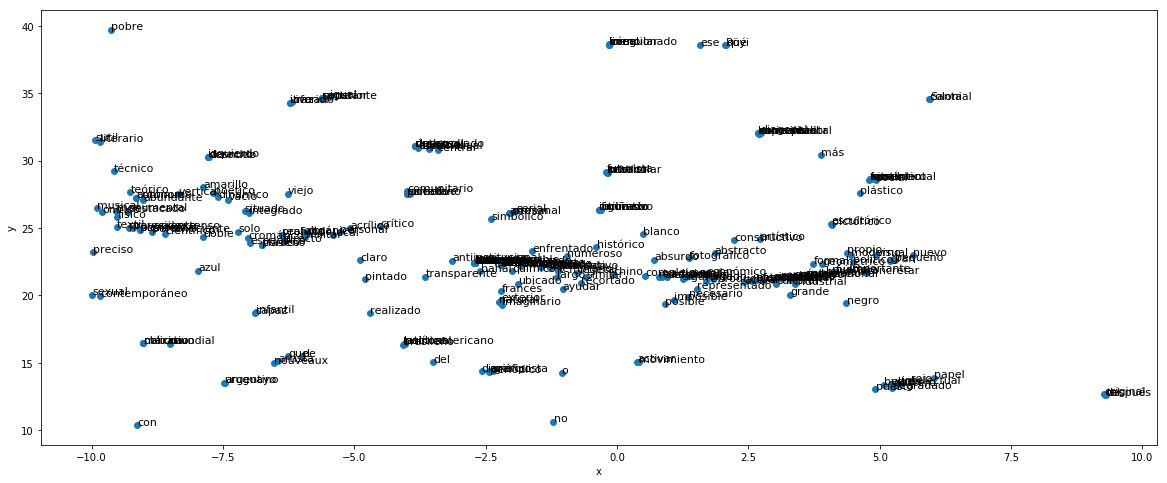

In [62]:
plot_region(x_bounds=(-10, 10), y_bounds=(10, 40))

In [63]:
def clustering(k):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(red_matrix, True)
    return clusters

In [ ]:
c50 =  clustering(50)
c100 = clustering(100)
c150 = clustering(150)

/home/work/anaconda3/lib/python3.8/site-packages/nltk/cluster/util.py:131: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


In [ ]:
filename = "trained/lavoz_cluster50.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c50, fileObj)
fileObj.close()

In [ ]:
filename = "trained/lavoz_cluster100.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c100, fileObj)
fileObj.close()

In [ ]:
filename = "trained/lavoz_cluster150.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c150, fileObj)
fileObj.close()

In [ ]:
filename = "trained/lavoz_cluster100.pickle"
with open(filename, 'rb') as f:
    clusters = pickle.load(f)

In [ ]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)

In [ ]:
pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [ ]:
def plot_region_cluster(x_bounds, y_bounds):
    slice = pointscluster[
        (x_bounds[0] <= pointscluster.x) &
        (pointscluster.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointscluster.y) &
        (pointscluster.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

# Word2vec

In [39]:
np.mean([len(s) for s in sents_tokens])

35.2775570272259

In [54]:
windows_size = 7
vector_size = 20
min_count = 5
epochs = 200
w2v_model = Word2Vec(sents_tokens, size=vector_size, window=windows_size, min_count=min_count,iter=epochs, workers=4, seed=1)
w2v_model.save(f"word2vec_size={vector_size}__window={windows_size}__min_count={min_count}__epochs={epochs}.model")

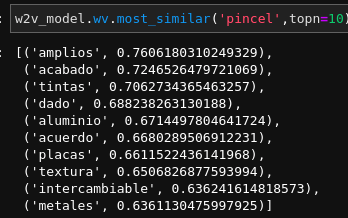

In [67]:
f'word2vec_size={vector_size}__window={windows_size}__min_count={min_count}__epochs={epochs}'

'word2vec_size=20__window=7__min_count=5__epochs=200'

In [55]:
len(w2v_model.wv.index2word)

4907

In [66]:
w2v_model.wv.most_similar('pincel',topn=10)

[('amplios', 0.7606180310249329),
 ('acabado', 0.7246526479721069),
 ('tintas', 0.7062734365463257),
 ('dado', 0.688238263130188),
 ('aluminio', 0.6714497804641724),
 ('acuerdo', 0.6680289506912231),
 ('placas', 0.6611522436141968),
 ('textura', 0.6506826877593994),
 ('intercambiable', 0.636241614818573),
 ('metales', 0.6361130475997925)]

In [68]:
w2v = WordEmbedding(wv=w2v_model.wv)

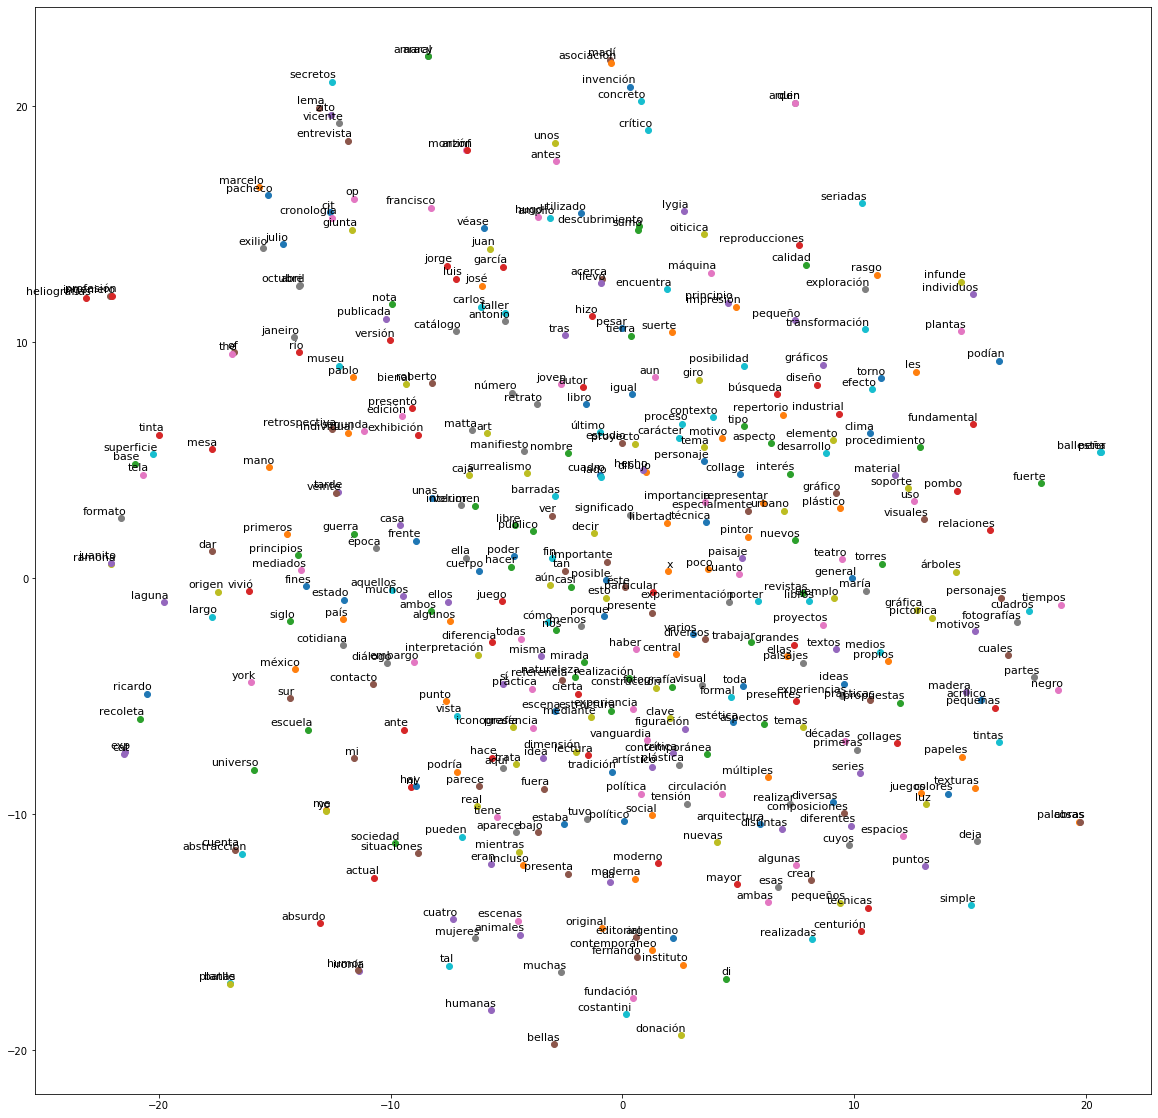

In [69]:
w2v.plot_tsne_proyection()

# Fasttext

In [70]:
from gensim.models.fasttext import FastText

In [71]:
windows_size = 5
vector_size = 10
min_count = 2
epochs=50

In [72]:
ft_model = FastText(
    size=vector_size, 
    window=windows_size,
    min_count=min_count,
)

In [73]:
ft_model.build_vocab(sentences=sents_tokens)

In [74]:
ft_model.train(sentences=sents_tokens, total_examples=len(sents_tokens), epochs=epochs)  # train
ft_model.save(f"fasttext__size={vector_size}__window={windows_size}__min_count={min_count}__epochs={epochs}.model")

In [75]:
ft = WordEmbedding(wv=ft_model.wv)

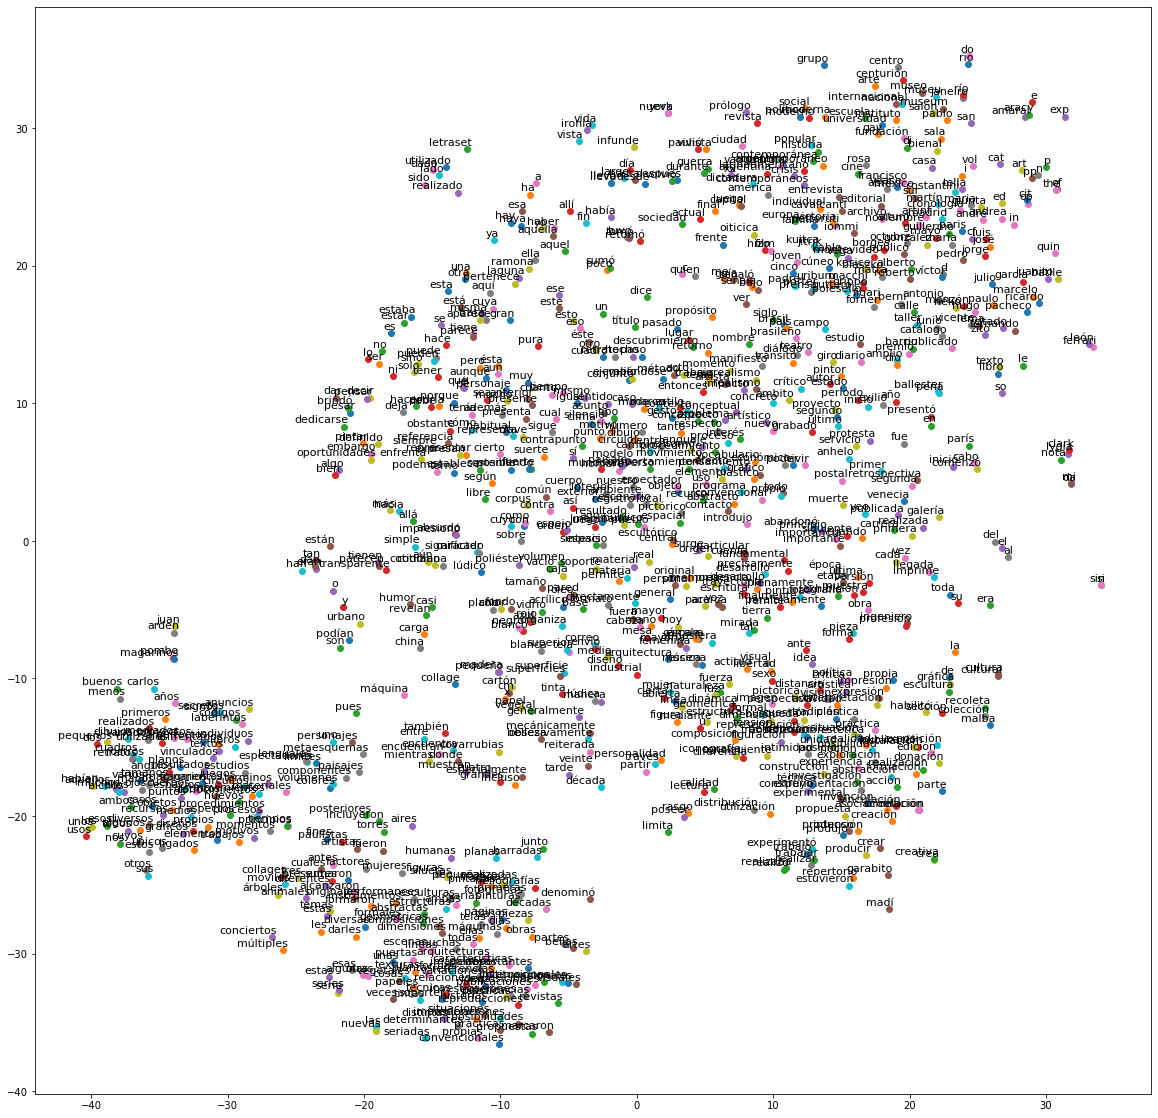

In [76]:
ft.plot_tsne_proyection(id_range=(0,1000))

Me gusta más Fasstext, incluso en la proyección ya se pueden observar cosas más interesantes

# Clustering

In [77]:
n_clusters = 50

In [78]:
ft.train_clustering(
    n_clusters=n_clusters,
    clustering_method='agglomerative')

In [79]:
ft.print_clustering_results()

46
['de', 'la', 'y', 'escultura', 'gráfica', 'distribución', 'arbitraria', 'heliográfica', 'requiriera', 'etc', 'fotográfica', 'mezcla', 'iconográfica', 'generó', 'mecánica', 'pesadilla', 'masculina', 'repleta', 'xilográfica', 'esperanza', 'polisémica', 'anuncian', 'tranquila', 'arbitrariedad', 'volcánica', 'alojó', 'autobiográfica', 'cinematográfica', 'biográfica']

----------------------------------------
22
['en', 'fue', 'año', 'berni', 'después', 'parís', 'antonio', 'taller', 'peña', 'ballester', 'cuatro', 'tarde', 'presentó', 'figari', 'volvió', 'film', 'pintó', 'transitó', 'diez', 'viajó', 'estadía', 'seis', 'enrique', 'empezó', 'emergen', 'apareció', 'bronce', 'obtuvo', 'españa', 'selva', 'recién', 'sede', 'sellawaj', 'bautizó', 'films', 'avance', 'pichon', 'visitó', 'usp', 'moma', 'antoni', 'mudó', 'rubén', 'tardía', 'homónima', 'frecuentó', 'muerto', 'sucedió', 'talabot', 'filmó', 'self', 'figueiredo', 'caricaturista', 'all', 'trelew', 'agregó', 'filho', 'ave', 'wall', 'antone

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

In [ ]:
kmeans.labels_

In [ ]:
from collections import defaultdict

In [ ]:
word_clusters = defaultdict(list)
for word,label in zip(ft_vectors.index2word , kmeans.labels_):
    word_clusters[label].append(word)

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.viridis
norm = Normalize(vmin=0, vmax=n_clusters)

In [ ]:
word_by_cluster = {word:cluster for word,cluster in zip(ft_vectors.index2word,kmeans.labels_)}

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pylab as plt

# obtener las palabras más comunes en el corpus, entre la 200 y la 600
words = [word for word in model_wv.index2word[200:1000]]

# convertirlas a vector
embeddings = [model_wv[word] for word in words]

#  T-SNEde
words_embedded = TSNE(n_components=2, random_state=1).fit_transform(embeddings)

# ... and visualize!
plt.figure(figsize=(20, 20))
for i, label in enumerate(words):
    x, y = words_embedded[i, :]
    cluster_color = cmap(norm(word_by_cluster[label]))
    plt.scatter(x, y, c=cluster_color)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom', size=11)
plt.show()

# Conversion a vector de TFIDF de oraciones

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
nltk_stopwords = nltk.corpus.stopwords.words('spanish')

In [ ]:
tfidf = TfidfVectorizer(stop_words=nltk_stopwords,min_df=2)

In [ ]:
tfidf_sents = [" ".join(sent) for sent in norm_sents]

In [ ]:
tfidf_matrix = tfidf.fit_transform(tfidf_sents)

### Construiimos el vector de cada palabra como su ocurrencia en oraciones

In [ ]:
word_matrix = tfidf_matrix.transpose()

In [ ]:
word_matrix

# AgglomerativeClustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
agc = AgglomerativeClustering(
    affinity='cosine',
    n_clusters=100,
    linkage='average')

In [ ]:
agc.n_clusters_

In [ ]:
clusters = agc.fit_predict(word_matrix.toarray())